# Load Packages and Data

In [1192]:
from IPython.display import HTML
hidecode=HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1187]:
hidecode

In [1193]:
% matplotlib inline
import numpy as np
import pandas as pd
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
import nltk
import re
from ipywidgets import interact, interactive, fixed, HBox, widgets
from collections import Counter
import operator

In [1194]:
df = pd.read_csv('webmd1.csv')

In [1240]:
df.head()

,Type,EstimatedPrice,HowtoUse,Form,EaseofUse,Allergies,Review,Interactions,GenName,Use,Drug,Sides,Satisfaction,BrandName,Indication,PkgCount,Precautions,Effectiveness,AvoidUse,Dosage,Condition
0,rx,,Read the Medication Guide provided by your p...,,5,,1 User Reviews,"Beta-blocker medications (such as metoprolol, ...",DAPAGLIFLOZIN PROPANEDIOL,Dapagliflozin is used with a proper diet and ...,dapagliflozin oral,"Frequent urination , dizziness , or lighthead...",5,,label,,"Before taking dapagliflozin, tell your doctor ...",5,"Chronic Heart Failure, Mild to Moderate Kidney...",,Prevention of Type 2 Diabetes Mellitus
1,rx,,Read the Patient Information Leaflet if availa...,,5,,1 User Reviews,"Beta-blocker medications (such as metoprolol, ...",EMPAGLIFLOZIN,Empagliflozin is used with a proper diet and ...,empagliflozin oral,"Frequent urination , dizziness , or lighthead...",5,,label,,"Before taking empagliflozin, tell your doctor ...",5,"Severe Renal Impairment, Mild to Moderate Kidn...",,Prevention of Type 2 Diabetes Mellitus
2,rx,,Read the Medication Guide provided by your pha...,,1,BIGUANIDES,1 User Reviews,"Many drugs can affect your blood sugar levels,...",DAPAGLIFLOZIN PROPANEDIOL/METFORMIN HCL,This medication is a combination of 2 drugs: d...,dapagliflozin-metformin oral,See also Warning section.,1,,label,,See also Warning section. Before taking this m...,3,"Alcohol Intoxication, Heart Attack, Chronic He...",,Prevention of Type 2 Diabetes Mellitus
3,otc,9.99,Consult your pharmacist.,tablet,,CALCIUM CALCIUM CARBONATE MAGNESIUM OXIDE M...,Be the first to review it,Keep a list of all your medications with you...,,Consult your pharmacist.,Calcium Magnesium oral,Consult your pharmacist.,,,label,30,Consult your pharmacist.,,"Tumor that Dissolves Bone, Incomplete or Infre...",,Prevention of a Low Amount of Calcium in the B...
4,rx,398.3039,Read the Medication Guide provided by your pha...,tablet,,"GLIPTINS (DPP-4 INHIBITORS) (DO NOT USE, NOT ...",Be the first to review it,Other medications can affect the removal of th...,ALOGLIPTIN BENZOATE/PIOGLITAZONE HCL,This combination medication is used with a pro...,alogliptin-pioglitazone oral,See also Warning section.,,,label,30,"Before taking this medication, tell your docto...",,"Macular Edema, Chronic Heart Failure, Severe H...",25 mg,Prevention of Type 2 Diabetes Mellitus


# Data Manipulation

In [561]:
hidecode

In [1196]:
otc = df[df.Type == ' otc']
cols = ['Type','Indication','Condition','Drug','BrandName','GenName','Use','HowtoUse','Precautions','AvoidUse',\
              'Allergies','Interactions','Sides','Effectiveness','EaseofUse','Satisfaction',\
              'Review','Form','Dosage','PkgCount','EstimatedPrice']
otc = otc[cols]
otc.rename(columns = {'Review':'Reviews'}, inplace=True) # rename to Reviews
otc.reset_index(drop=True, inplace=True)

In [1197]:
ind = otc.loc[(otc.Reviews == 'Be the first to review it') &\
        ((otc.Effectiveness != ' ') | (otc.EaseofUse != ' ') | (otc.Satisfaction != ' '))].index
otc.loc[ind,'Reviews'] = 1 # fix rows with ratings but no reviews

ind2 = otc.loc[otc.Reviews == 'Be the first to review it'].index
otc.loc[ind2, 'Reviews'] = 0 # change rows with no reviews to value 0

ind3 = otc.loc[(otc.Reviews != 0)&(otc.Reviews.str.contains('User Reviews'))].index
otc.loc[ind3, 'Reviews'] = otc.loc[ind3].Reviews.str.replace('User Reviews', '') # remove text from reviews

otc.Reviews = pd.to_numeric(otc.Reviews) # convert to numeric

In [1198]:
otc.loc[otc.Reviews == 0,['Effectiveness','EaseofUse','Satisfaction']] = np.nan

In [1199]:
otc.loc[otc.loc[otc.BrandName == ' '].index,'BrandName'] = ''
otc.loc[otc.loc[otc.GenName == ' '].index, 'GenName'] = ''
otc.loc[otc.loc[otc.Dosage == ' '].index, 'Dosage'] = ''
otc.loc[otc.loc[otc.Use == ' '].index, 'Use'] = ''
otc.loc[otc.loc[otc.HowtoUse == ' '].index, 'HowtoUse'] = ''
otc.loc[otc.loc[otc.Precautions == ' '].index, 'Precautions'] = ''
otc.loc[otc.loc[otc.Interactions == ' '].index, 'Interactions'] = ''
otc.loc[otc.loc[otc.Sides == ' '].index, 'Sides'] = ''
otc.loc[otc.loc[otc.Allergies == ' '].index, 'Allergies'] = ''
otc.loc[otc.loc[otc.AvoidUse == ' '].index, 'AvoidUse'] = ''

In [1200]:
otc.loc[otc.loc[(otc.Form == ' ') & (otc.PkgCount == ' ') & (otc.EstimatedPrice == ' ')].index,\
       ['Form','PkgCount','EstimatedPrice']] = np.nan

In [1201]:
otc.Satisfaction = pd.to_numeric(otc.Satisfaction)
otc.EaseofUse = pd.to_numeric(otc.EaseofUse)
otc.Effectiveness = pd.to_numeric(otc.Effectiveness)
otc.EstimatedPrice = pd.to_numeric(otc.EstimatedPrice)
otc.PkgCount = pd.to_numeric(otc.PkgCount)
otc = otc.assign(UnitPrice = otc.EstimatedPrice/otc.PkgCount)
otc = otc.assign(Overall = (otc.Effectiveness+otc.EaseofUse+otc.Satisfaction)/3)

In [1241]:
otc.dropna().sort_values('Drug').head()

,Type,Indication,Condition,Drug,BrandName,GenName,Use,HowtoUse,Precautions,AvoidUse,Allergies,Interactions,Sides,Effectiveness,EaseofUse,Satisfaction,Reviews,Form,Dosage,PkgCount,EstimatedPrice,UnitPrice,Overall
15220,otc,label,Stuffy Nose,12 Hour Cold Relief oral,,PSEUDOEPHEDRINE HCL,Pseudoephedrine is used for the temporary rel...,If you are taking the over-the-counter product...,"Before taking pseudoephedrine, tell your docto...","closed angle glaucoma, High Blood Pressure, Se...",SYMPATHOMIMETIC AGENTS EPHEDRINE ANALOGUES,To help your doctor and pharmacist give you th...,"Nausea , vomiting , trouble sleeping , dizz...",5.0,5.0,5.0,1,tablet,120 mg,20.0,12.9880,0.649400,5.000000
15253,otc,label,Stuffy Nose,12 Hour Decongestant oral,,PSEUDOEPHEDRINE HCL,Pseudoephedrine is used for the temporary rel...,If you are taking the over-the-counter product...,"Before taking pseudoephedrine, tell your docto...","closed angle glaucoma, High Blood Pressure, Se...",SYMPATHOMIMETIC AGENTS EPHEDRINE ANALOGUES,To help your doctor and pharmacist give you th...,"Nausea , vomiting , trouble sleeping , dizz...",4.0,4.0,4.0,1,tablet,120 mg,20.0,12.9880,0.649400,4.000000
14611,otc,label,Stuffy Nose,12 Hour Nasal Relief Spray,,OXYMETAZOLINE HCL,This medication is used for temporary relief...,Use this medication in the nose as directed. F...,"Before using this nasal decongestant , tell y...","closed angle glaucoma, High Blood Pressure, Di...",SYMPATHOMIMETIC AGENTS,Taking MAO inhibitors with this medication may...,"Temporary burning, stinging, dryness in the no...",2.0,4.0,2.0,1,spray,,30.0,11.0281,0.367603,2.666667
13853,otc,label,Runny Nose,12 Hour Nasal Relief Spray,,OXYMETAZOLINE HCL,This medication is used for temporary relief...,Use this medication in the nose as directed. F...,"Before using this nasal decongestant , tell y...","closed angle glaucoma, High Blood Pressure, Di...",SYMPATHOMIMETIC AGENTS,Taking MAO inhibitors with this medication may...,"Temporary burning, stinging, dryness in the no...",2.0,4.0,2.0,1,spray,,30.0,11.0281,0.367603,2.666667
3195,otc,label,Painful Periods,8 HOUR PAIN RELIEVER oral,,ACETAMINOPHEN,This drug is used to treat mild to moderate pa...,Take this product by mouth as directed. Foll...,See also Warning section. Before taking acetam...,"Acute Liver Failure, Liver Problems, Severe Re...",ACETAMINOPHEN,Drug interactions may change how your medicat...,See also Warning section.,3.0,4.0,3.0,1,liquid,160 mg,118.0,8.8800,0.075254,3.333333


# Data Visualization

In [423]:
hidecode

In [1203]:
colFun = {'Drug':['size'],'Reviews':['max','median','sum'],\
                                'EaseofUse':['max','median'],'Satisfaction':['max','median'],\
                               'Effectiveness':['max','median'],'EstimatedPrice':['mean']}

group = otc.groupby(['Condition']).agg(colFun)
groupcols = ['Drug','Effectiveness','EaseofUse','Satisfaction','Reviews','EstimatedPrice']
#group.loc[group.Drug.sort_values('size',ascending=False).index][groupcols]
group1 = group.loc[group['Reviews'].sort_values('sum',ascending=False).index][groupcols]
group1.head()

Drug Effectiveness         \
                                                   size           max median   
Condition                                                                      
Cough                                               637           5.0    4.0   
Cold Symptoms                                       625           5.0    4.0   
Stuffy Nose                                         817           5.0    4.0   
Runny Nose Due to Grass Pollen                      596           5.0    4.0   
Severe Inflammation of Nasal Lining due to an A...  595           5.0    4.0   

                                                   EaseofUse            \
                                                         max    median   
Condition                                                                
Cough                                                    5.0  4.500000   
Cold Symptoms                                            5.0  4.500000   
Stuffy Nose                                              5.0  4.472222   
Runny Nose Due to Grass Pollen                           5.0  4.444445   
Severe Inflammation of Nasal Lining due to an A...       5.0  4.444445   

                                                   Satisfaction            \
                                                            max    median   
Condition                                                                   
Cough                                                       5.0  3.775000   
Cold Symptoms                                               5.0  3.784615   
Stuffy Nose                                                 5.0  4.000000   
Runny Nose Due to Grass Pollen                              5.0  4.000000   
Severe Inflammation of Nasal Lining due to an A...          5.0  4.000000   

                                                   Reviews               \
                                                       max median   sum   
Condition                                                                 
Cough                                                  439    0.0  2054   
Cold Symptoms                                          439    0.0  1715   
Stuffy Nose                                            185    0.0  1660   
Runny Nose Due to Grass Pollen                         185    0.0  1645   
Severe Inflammation of Nasal Lining due to an A...     185    0.0  1645   

                                                   EstimatedPrice  
                                                             mean  
Condition                                                          
Cough                                                   15.241122  
Cold Symptoms                                           16.482972  
Stuffy Nose                                             16.284499  
Runny Nose Due to Grass Pollen                          17.854200  
Severe Inflammation of Nasal Lining due to an A...      17.845245

### Forms of Drugs

In [1204]:
pd.options.display.max_columns = 100

In [1205]:
otc_form = otc[['Form','PkgCount','UnitPrice','EstimatedPrice','EaseofUse','Effectiveness','Satisfaction','Overall','Indication']]
formind = otc_form.sort_values('Form').Form.value_counts().index[0:13] # create a list of top drug forms
otc_form = otc_form.reset_index(drop=True).set_index('Form').loc[formind].reset_index() #select top 

forms = pd.DataFrame(otc.sort_values('Form').Form.value_counts()).rename(columns={'Form':'count'})
forms = forms.assign(percentage = forms[['count']]/forms[['count']].sum())

Top 13 out of 51 forms of drugs makes up of 95.1% all OTC drugs


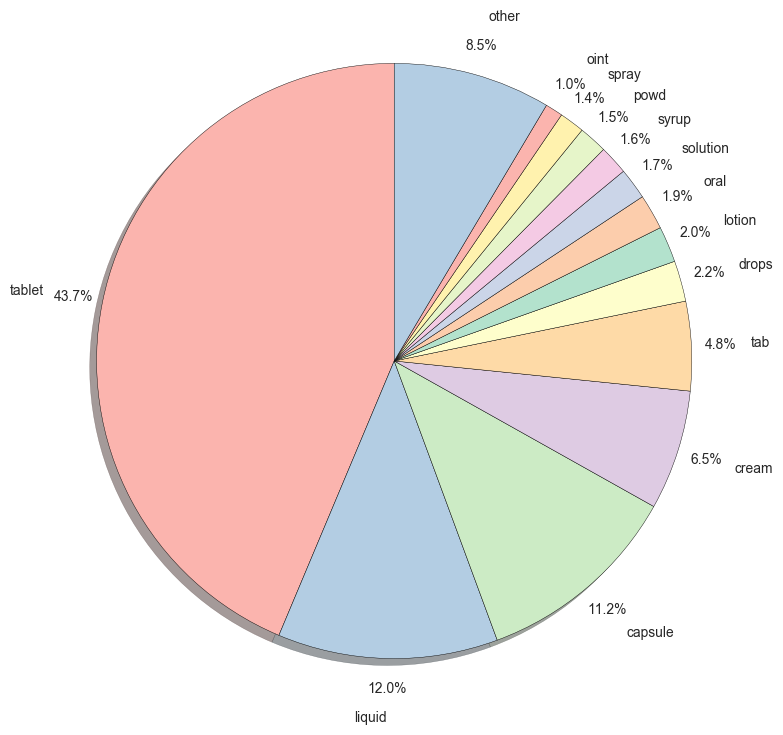

In [1206]:
sizes = [x*100 for x in forms['percentage'].tolist()[0:13]] + [100-sum([x*100 for x in forms['percentage'].tolist()[0:10]])]
labels = forms.index.tolist()[0:13] + ['other']
fig = plt.figure(figsize=(8,8))
pieWedgesCollection = plt.pie(sizes,labels=(labels),
                              colors=(sns.color_palette("Pastel1")+sns.color_palette("Pastel2")),
                              startangle=90,
                              autopct='%1.1f%%',
                              shadow=True,
                              radius = 1.2,
                              pctdistance=1.1, labeldistance=1.2)
print 'Top %d out of 51 forms of drugs makes up of %s all OTC drugs' %(len(sizes)-1,'{:.1%}'.format(forms.loc[formind]['percentage'].sum()))

<function __main__.formplot>

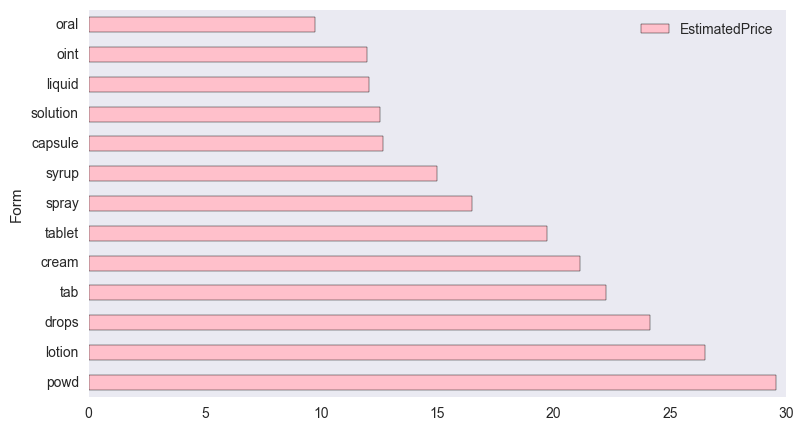

In [1207]:
def formplot(x):
    otc_ = otc_form
    return otc_.groupby('Form')[[x]].agg('mean').sort_values(x,ascending=False).plot.barh(figsize=(9,5),
                                                                                         color='pink').legend(loc='upper right')

interact(formplot,
        x= widgets.Dropdown(
        options=['PkgCount','EstimatedPrice','EaseofUse','Effectiveness','Satisfaction','UnitPrice'],
        value='EstimatedPrice',
        description='Form vs:',
        disabled=False,
        button_style='info')
        )

Null Hypothesis: The variance of effectiveness are equal across all forms of drugs

BartlettResult(statistic=150.35231224453142, pvalue=4.8094147391152934e-26)

The Bartlett's Test tells us our variances are the same, which allows us to perform the ANOVA test

Null Hypothesis: The effectiveness of all forms of drugs are equal

F_onewayResult(statistic=7.3077598764218541, pvalue=1.6657279383534421e-13)

Using a one-way ANOVA, we fail to reject the null hypothesis due to a very low pvalue of ~ 1.6e-13


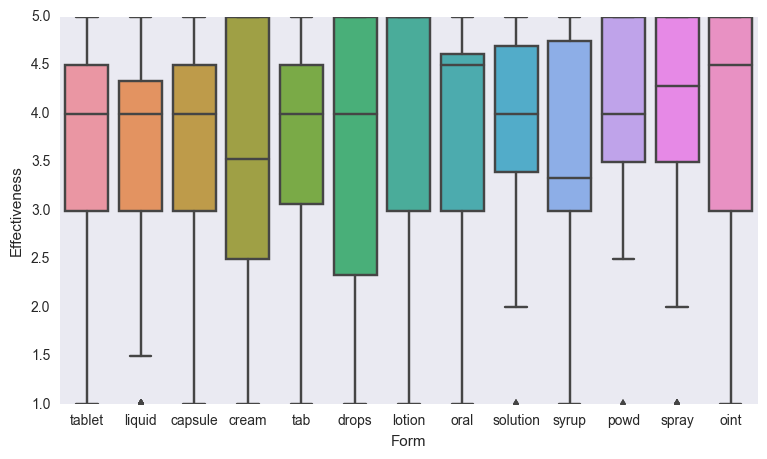

In [1208]:
plt.figure(figsize=(9,5))
sns.boxplot(x='Form',y='Effectiveness', data=otc_form)

grps = pd.unique(otc_form.Form.values)
d_data = {grp:otc_form.dropna()['Effectiveness'][otc_form.Form == grp] \
    for grp in pd.unique(otc_form.Form.values)}
 
k = len(pd.unique(otc_form.Form))  # number of conditions
N = len(otc_form.values)  # conditions times participants
n = otc_form.groupby('Form').size()[0] #Participants in each condition
print 'Null Hypothesis: The variance of effectiveness are equal across all forms of drugs\n'
print stats.bartlett(d_data['tablet'],d_data['liquid'],d_data['capsule'],d_data['cream'],d_data['tab'],d_data['drops'],
                     d_data['lotion'],d_data['oral'],d_data['solution'],d_data['syrup'],d_data['powd'],d_data['spray'],
                     d_data['oint'])
print '\nThe Bartlett\'s Test tells us our variances are the same, which allows us to perform the ANOVA test\n'
print 'Null Hypothesis: The effectiveness of all forms of drugs are equal\n'
print stats.f_oneway(d_data['tablet'],d_data['liquid'],d_data['capsule'],d_data['cream'],d_data['tab'],d_data['drops'],
                     d_data['lotion'],d_data['oral'],d_data['solution'],d_data['syrup'],d_data['powd'],d_data['spray'],
                     d_data['oint']) 
print '\nUsing a one-way ANOVA, we fail to reject the null hypothesis due to a very low pvalue of ~ 1.6e-13'

In [1209]:
otclog = otc_form[['Form','Indication','EstimatedPrice']]
otclog.loc[:,'EstimatedPrice'] = np.log(otcbox.EstimatedPrice)

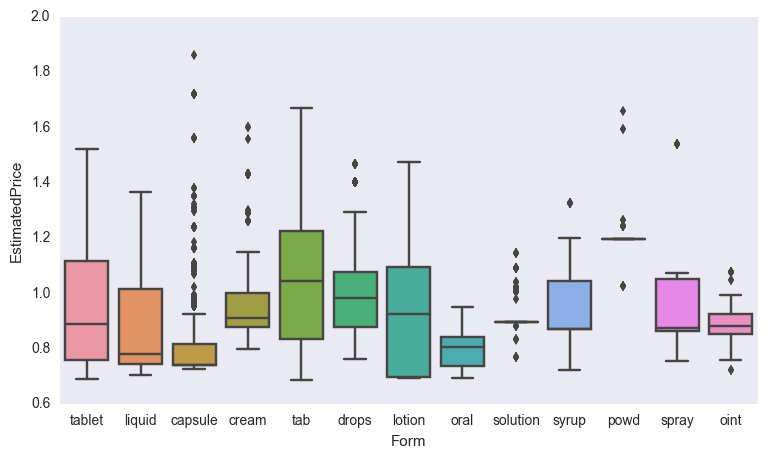

In [1210]:
plt.figure(figsize=(9,5))
sns.boxplot(x='Form',y='EstimatedPrice', data=otclog)

#### Brand name vs Generic

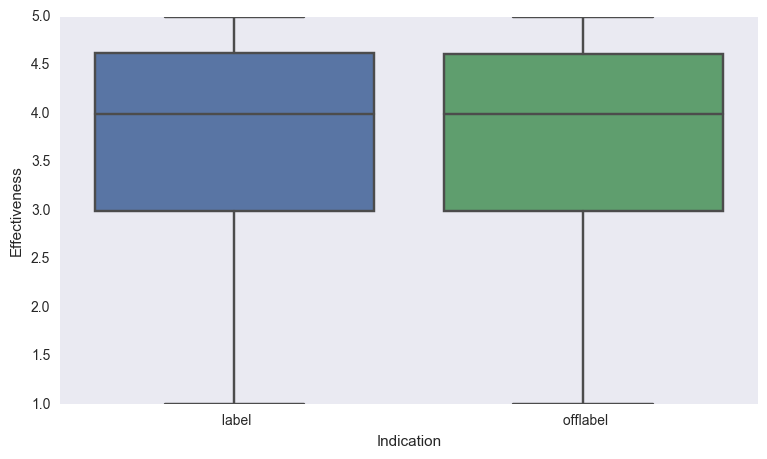

In [1211]:
plt.figure(figsize=(9,5))
sns.boxplot(x='Indication',y='Effectiveness', data=otc_form)

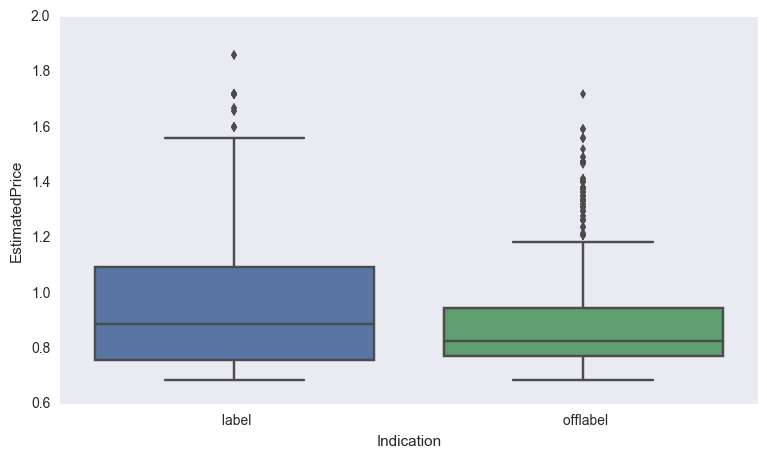

In [1212]:
plt.figure(figsize=(9,5))
sns.boxplot(x='Indication',y='EstimatedPrice', data=otclog)

### Ease of Use vs Effectiveness to User Satisfaction

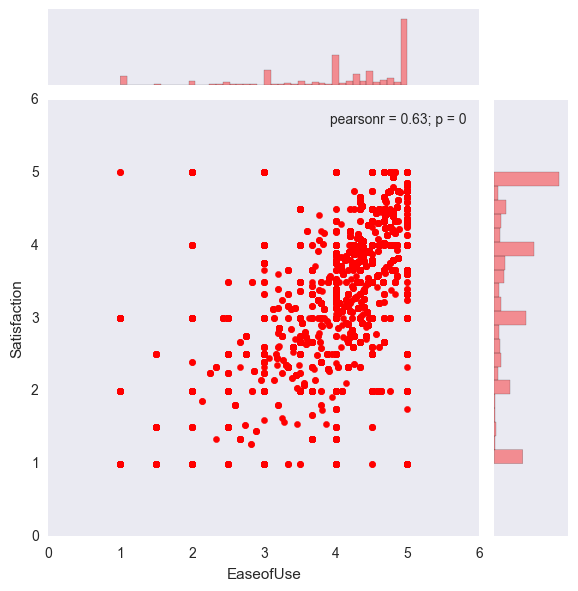

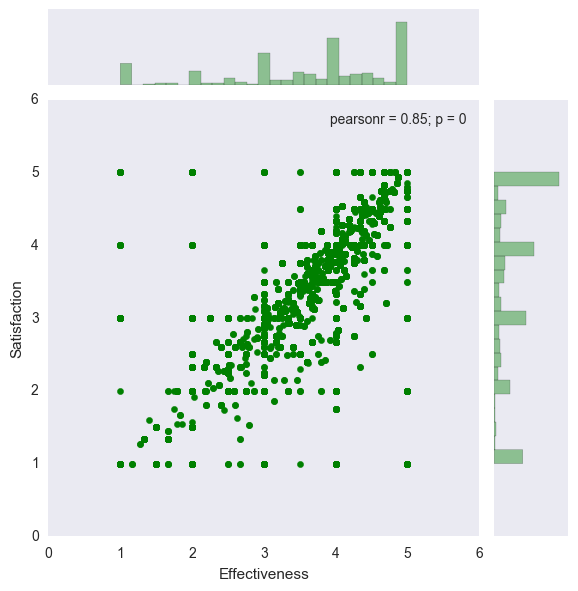

In [1213]:
def jointplot(x,color='g'):
    otcjoint = otc[['EaseofUse', 'Satisfaction', 'Effectiveness', 'Reviews', 'EstimatedPrice']]
    otcjoint = otcjoint[otcjoint.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
    return sns.jointplot(x, otc.Satisfaction,color=color)
plt.figure(figsize=(9,5))

jointplot(otc.EaseofUse,'r')
jointplot(otc.Effectiveness)

In [1214]:
otc[['EaseofUse','Effectiveness','Satisfaction','Overall']].corr()

,EaseofUse,Effectiveness,Satisfaction,Overall
EaseofUse,1.000000,0.653282,0.631671,0.828771
Effectiveness,0.653282,1.000000,0.849892,0.933957
Satisfaction,0.631671,0.849892,1.000000,0.931822
Overall,0.828771,0.933957,0.931822,1.000000


### Other Plots

#### Reviews

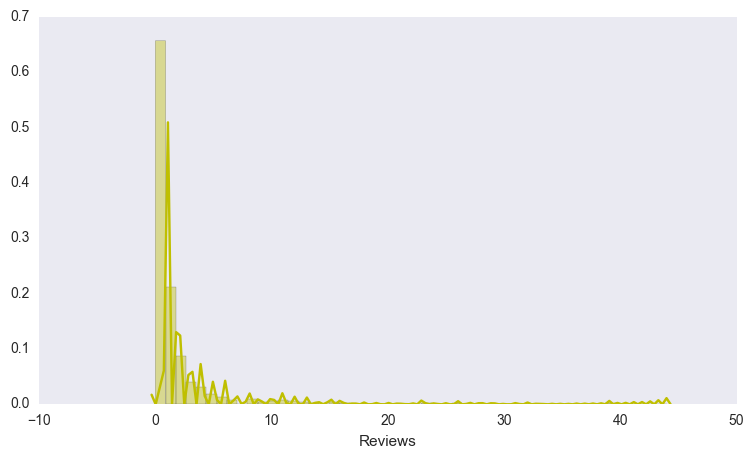

In [1239]:
def Histo_Reviews(x,y):
    otchist = otc[['Reviews']].dropna()
    otchist.loc['Reviews'] = np.log(otchist.Reviews)
    otchist = otchist.loc[(otchist.Reviews >= x)&(otchist.Reviews <= y)]
    otchist = otchist[otchist.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
    plt.figure(figsize=(9,5))
    return sns.distplot(otchist.Reviews,color='y')

# Histo_Reviews()
interact(Histo_Reviews,
    x= widgets.IntSlider(
    min=0,
    value = 5,
    step = 10,
    max=200,
    description='Minimum Reviews:'),
    y= widgets.IntSlider(
    min=0,
    value = 200,
    step = 10,
    max=390,
    description='Max Reviews:')
         )


#### Reviews vs Price

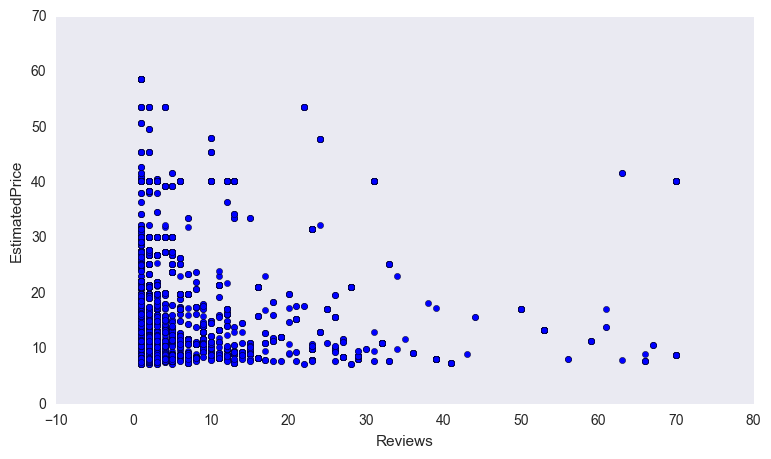

In [1235]:
def Reviews_vs_Price(x,y):
    otcscatter = otc[['Reviews','EstimatedPrice']]
    otcscatter = otcscatter.loc[(otcscatter.Reviews > x[0])&(otcscatter.Reviews < x[1])&
                                (otcscatter.EstimatedPrice > y[0])&(otcscatter.EstimatedPrice < y[1])]
    otcscatter = otcscatter[otcscatter.apply(lambda x: np.abs(x - x.mean()) / x.std() < 3).all(axis=1)]
    return otcscatter.plot.scatter('Reviews','EstimatedPrice',figsize=(9,5), color = 'blue')
   
interact(Reviews_vs_Price,
    x= widgets.IntRangeSlider(
    min=0,
    value = [0,390],
    step = 10,
    max=390,
    description='Reviews:'),
    y= widgets.IntRangeSlider(
    min=0,
    value = [0,150],
    step = 5,
    max=150,
    description='Price:')
        )    


#### All Continuous Vars

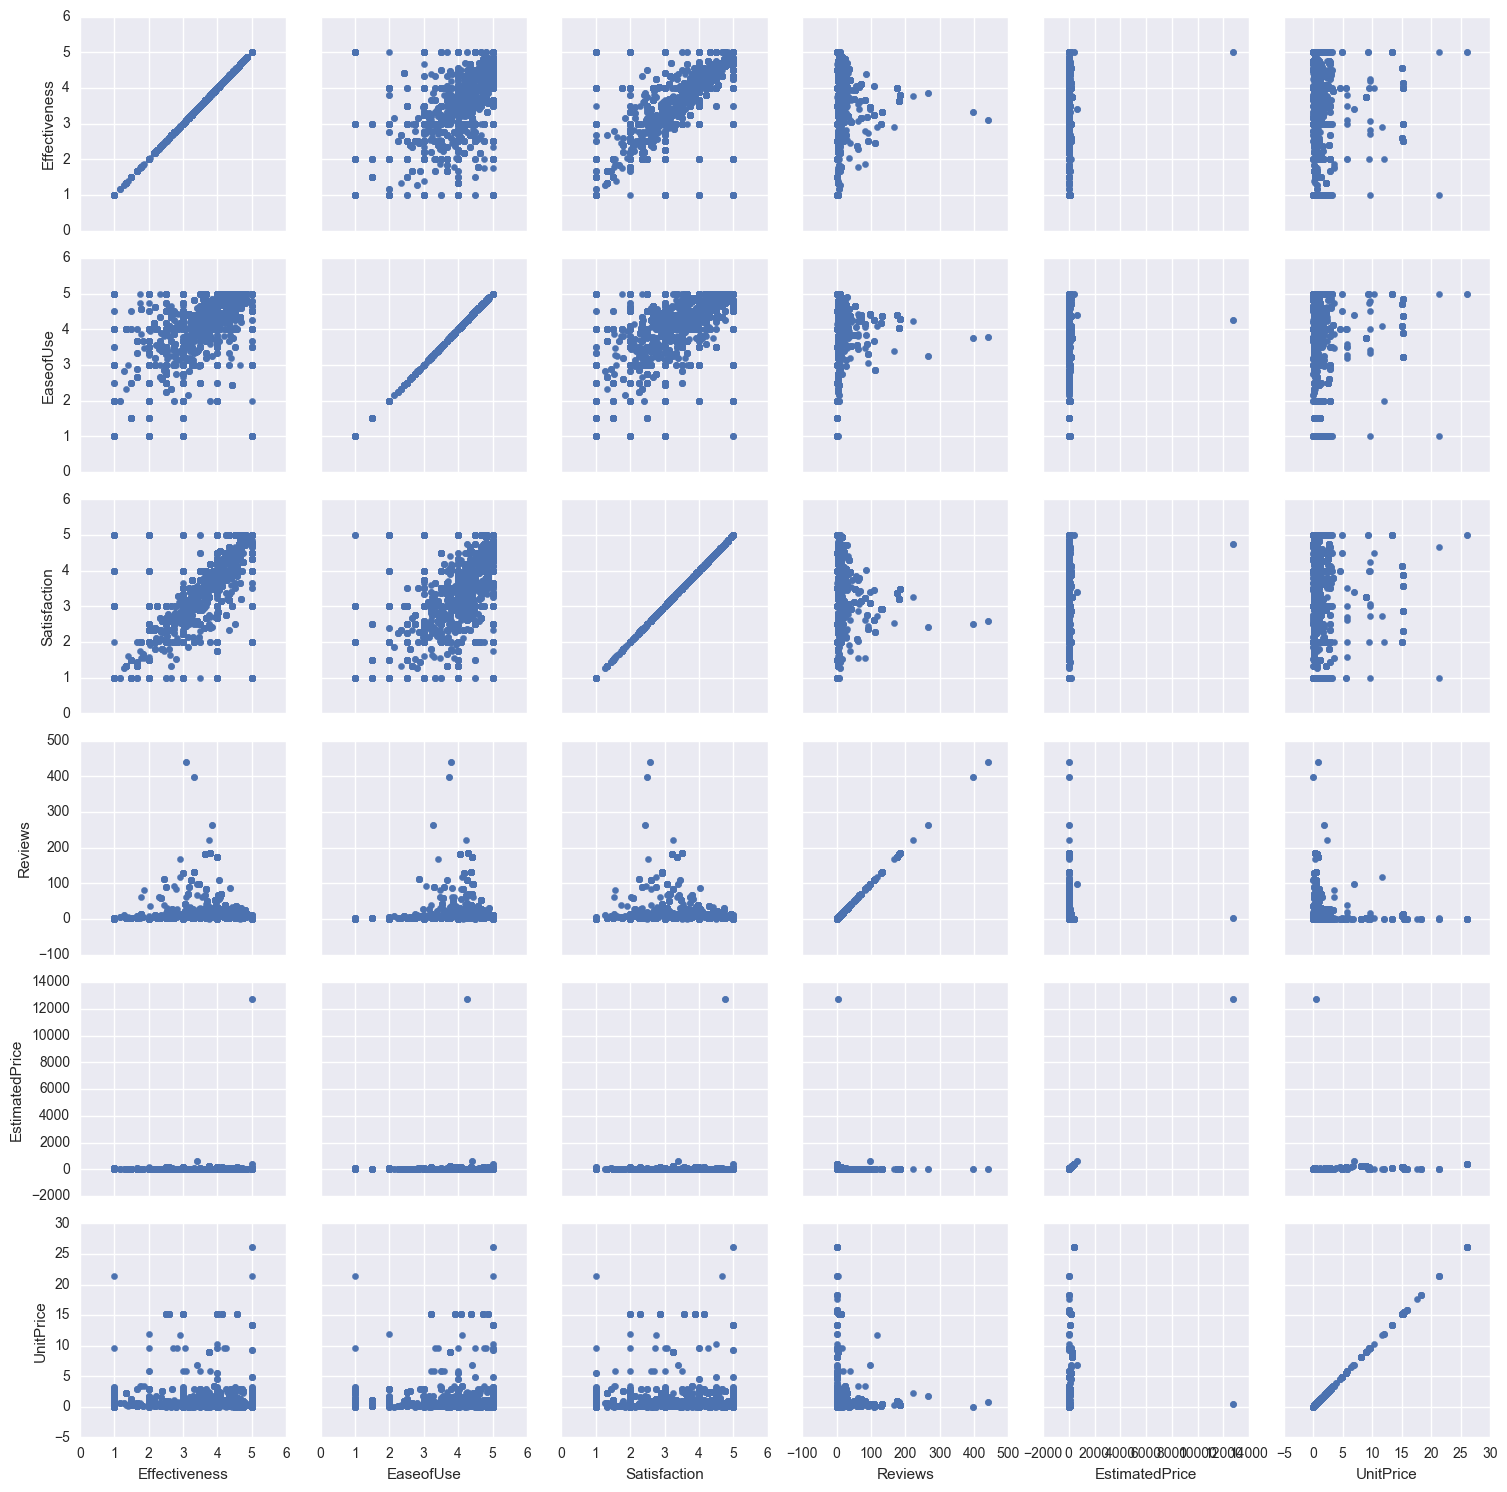

In [929]:
g = sns.PairGrid(otc[['Effectiveness','EaseofUse','Satisfaction','Reviews','EstimatedPrice','UnitPrice']])
g.map(plt.scatter)
# g.map_lower(plt.kdeplot)
# g.map_upper(plt.hist)

# Robot Pharamist OTC Drug Finder

In [563]:
hidecode

In [919]:
#['Use','HowtoUse','Precautions','AvoidUse','Allergies','Interactions','Sides''BrandName','GenName',] # columns removed
def search_conditions(string, tg2, tg3, age, dd1, tg1, na, conds, form, count, revrange, currmed, health):
    search = ['Indication','Condition','Drug',\
              'Effectiveness','EaseofUse','Satisfaction',\
              'Reviews','Form','Dosage','PkgCount','EstimatedPrice']
    index = []
    a1index = []
    df = otc
    if na:
        df = df.loc[(df.EaseofUse >= 0)&(df.EstimatedPrice >= 0)].reset_index(drop=True)
    
    if revrange:    
        df = df.loc[(df.Reviews >= revrange)].reset_index(drop=True)
    
    if form != 'All':
        df = df.loc[df.Form == form].reset_index(drop=True)
        
    if conds != '':
        conds = '(' + ')|('.join(conds) + ')'
    for i in range(len(df)):
        if re.search(conds.lower(), df.Allergies[i].lower()):
            a1index += [i]
        else:
            continue
    df = df[~df.index.isin(a1index)].reset_index(drop=True)
                    
    if tg2:
        for i in range(len(df)):
            if re.search('^'+string.lower()+'$', df.Condition[i].lower()):
                index += [i]
            else:
                continue
        return df[search].loc[index].sort_values(dd1, ascending=tg1).head(count).set_index('Drug')
    
    if tg3:
        regex = '^(?=.*\\b'+'\\b)(?=.*\\b'.join(string.lower().split())+'\\b).*$'
        for i in range(len(df)):
            if re.search(regex, df.Condition[i].lower()):
                index += [i]
            else:
                continue
        return df[search].loc[index].sort_values(dd1, ascending=tg1).head(count).set_index('Drug')
    
    else:
        for i in range(len(df)):
            if re.search(string.lower(), df.Condition[i].lower()):
                index += [i]
            else:
                continue
        return df[search].loc[index].sort_values(dd1, ascending=tg1).head(count).set_index('Drug') 
    
# search_conditions('cough',False,'False','','Effectiveness',False,True,'All',5) # for debugging only

### Widget Creation

In [920]:
allergstr = []
reg = re.compile(r"[\d+\w+]{2,}")
for i in range(len(otc.Allergies)):
    allergstr += nltk.word_tokenize(otc.Allergies[i])
allergstr = [x for x in list(set(allergstr)) if reg.match(x)]

In [921]:
tg1 = widgets.ToggleButton(
    value=False,
    description='Ascending/Descending',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

tg2 = widgets.ToggleButton(
    value=False,
    description='Match Exact',
    disabled=False,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

tg3 = widgets.ToggleButton(
    value=False,
    description='Match Term',
    disabled=False,
    button_style='success', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

dd1 = widgets.Dropdown(
    options={'Estimated Price': 'EstimatedPrice', 'Reviews': 'Reviews', 'Ease of Use': 'EaseofUse',\
            'Satisfaction': 'Satisfaction', 'Effectiveness': 'Effectiveness'},
    value='Reviews',
    description='Sort by:',
    disabled=False,
    button_style='info' # 'success', 'info', 'warning', 'danger' or ''
)

str1 = widgets.Text(
    value='Cough',
    placeholder='',
    description='Search:',
    disabled=False
)

int1 = widgets.IntSlider(
    value = 5,
    step = 1,
    min = 1,
    max = 10,
    description = 'Show:'
)

age1 = widgets.IntText(
    value = 35,
    step = 1,
    min = 1,
    max = 100,
    description = 'Age:'
)

na1 = widgets.ToggleButton(
    value=True,
    description='Remove NA',
    disabled=False,
    button_style='warning', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

for1 = widgets.Dropdown(
    options=['All'] + otc.Form.unique().tolist(),
    value='All',
    description='Form:',
    disabled=False,
    button_style='info' # 'success', 'info', 'warning', 'danger' or ''
)

revrange = widgets.IntSlider(
    value= 5,
    min=0,
    max= 50,
    step=5,
    description='Minimum Reviews:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='i',
    slider_color='white',
    color='black'
)

a= widgets.SelectMultiple(
    options=['NONE'] +sorted(allergstr),
    value=['NONE'],
    description='Allergies:',
    disabled=False
)

currmed = widgets.Text(
    value='',
    placeholder='',
    description='Current Meds:',
    disabled=False
)

health = widgets.Text(
    value='',
    placeholder='',
    description='Known Illnesses:',
    disabled=False
)

### Drug Finder

In [922]:
interactive(search_conditions,
            string = str1,
            tg1 = tg1,
            tg3 = tg3,
            conds = a,
            age = age1,
            dd1 = dd1,
            na = na1,
            tg2 = tg2,
            form = for1,
            count = int1,
            revrange = revrange,
            currmed = currmed,
            health = health,
            __manual=False)

,Indication,Condition,Effectiveness,EaseofUse,Satisfaction,Reviews,Form,Dosage,PkgCount,EstimatedPrice
Drug,,,,,,,,,,
Mucinex oral,label,Cough,3.086560,3.797266,2.583143,439,tab,600 mg,20.0,15.8220
Mucinex DM oral,label,Cough,3.321608,3.743719,2.492462,398,syrup,,240.0,10.9690
Benadryl oral,label,Cough,3.794595,4.291892,3.497297,185,capsule,25 mg,30.0,8.1898
ZzzQuil oral,label,Cough,3.333333,4.371212,2.931818,132,tablet,25 mg,20.0,8.4430
Mucinex D oral,label,Cough,3.674699,4.144578,3.240964,83,tab,,18.0,17.1630
